## Import du dataset et division en données normales / anormales 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import glob
import os

# Chemin vers le dossier contenant les fichiers .h5
dataset_path = "./Dataset"

# Liste de tous les fichiers .h5 dans le dossier
h5_files = glob.glob(os.path.join(dataset_path, "*.h5"))

# Listes pour stocker les DataFrames normaux et anormaux
normal_data_frames = []
anomaly_data_frames = []

# Charger chaque fichier .h5 dans un DataFrame et le classer
for file in h5_files:
    try:
        df = pd.read_hdf(file)
        
        # Identifier les fichiers anormaux par la présence de mots-clés dans le nom du fichier
        if "shift_on" in file:
            anomaly_data_frames.append(df)
            print(f"{file} classé comme anomalie.")
        else:
            normal_data_frames.append(df)
            print(f"{file} classé comme normal.")
            
    except Exception as e:
        print(f"Erreur lors du chargement de {file}: {e}")


./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset\TimeSeries_Scenario_00002_ScenarioInstanceRandint_id_0002.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00003_ScenarioInstanceRandint_id_0003.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00004_ScenarioInstanceRandint_id_0004.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00005_ScenarioInstanceRandint_id_0005.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset\TimeSeries_Scenario_00007_ScenarioInstanceRandint_id_0007.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00008_ScenarioInstanceRandin

In [3]:
# Calcul du pourcentage de données normales et anormales
total_files = len(h5_files)
normal_percentage = (len(normal_data_frames) / total_files) * 100 if total_files > 0 else 0
anomaly_percentage = (len(anomaly_data_frames) / total_files) * 100 if total_files > 0 else 0

# Afficher les pourcentages
print(f"Pourcentage de données normales : {normal_percentage:.2f}%")
print(f"Pourcentage de données anormales : {anomaly_percentage:.2f}%")

#nbr de séries temporelles normales 
print(len(normal_data_frames))
print(len(anomaly_data_frames))


Pourcentage de données normales : 96.35%
Pourcentage de données anormales : 3.65%
949
36


In [4]:
normal_data_frames[0].shape

(3582, 135)

In [5]:
def check_dataframe_sizes(dataframes):
    """
    Vérifie les tailles des DataFrames dans une liste.

    Paramètres:
    - dataframes (list): Liste contenant des DataFrames pandas.

    Retourne:
    - dict: Un dictionnaire où les clés sont les tailles (shape) et les valeurs sont 
            les indices des DataFrames correspondants.
    """
    size_dict = {}
    for i, df in enumerate(dataframes):
        size = df.shape
        if size not in size_dict:
            size_dict[size] = []
        size_dict[size].append(i)
    return size_dict

In [6]:
# Affichage des tailles de DataFrame
print("Tailles des DataFrames dans normal_data_frames:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans normal_data_frames:
Taille (3582, 135): 559 simulations
Taille (3583, 135): 341 simulations
Taille (3584, 135): 35 simulations
Taille (3581, 135): 13 simulations
Taille (3585, 135): 1 simulations


In [7]:
print("Tailles des DataFrames dans anomaly_data_frames:")
anormal_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anormal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans anomaly_data_frames:
Taille (3582, 137): 21 simulations
Taille (3583, 137): 15 simulations


In [8]:
# Uniformiser toutes les tailles des DataFrames à (3581, 135)
for i in range(len(normal_data_frames)):
    if normal_data_frames[i].shape[0] > 3581:
        # Supprimer les lignes excédentaires à partir de la fin
        normal_data_frames[i] = normal_data_frames[i].iloc[:3581, :]

for i in range(len(anomaly_data_frames)):
    if anomaly_data_frames[i].shape[0] > 3581:
        # Supprimer les lignes excédentaires à partir de la fin
        anomaly_data_frames[i] = anomaly_data_frames[i].iloc[:3581, :]

In [9]:
# Affichage des tailles après l'ajustement
print("Tailles des DataFrames dans normal_data_frames après l'ajustement:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

print("Tailles des DataFrames dans anomaly_data_frames après l'ajustement:")
anormal_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anormal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans normal_data_frames après l'ajustement:
Taille (3581, 135): 949 simulations
Tailles des DataFrames dans anomaly_data_frames après l'ajustement:
Taille (3581, 137): 36 simulations


### 1. Prise en main des données et préparation à l'entrainement. 

In [5]:
# visualisation (pour l'idéeà)
print(normal_data_frames[0])

      sim/cockpit/autopilot/flight_director_pitch  \
0                                        0.017744   
1                                       -0.070592   
2                                       -0.179166   
3                                       -0.284005   
4                                       -0.365164   
...                                           ...   
3577                                     5.067928   
3578                                     5.068606   
3579                                     5.069308   
3580                                     5.069987   
3581                                     5.070647   

      sim/cockpit/autopilot/flight_director_roll  \
0                                      -0.224200   
1                                      -0.124244   
2                                      -0.124244   
3                                      -0.124244   
4                                      -0.124244   
...                                          ...   

### Identifier les colonnes anomalies 

In [10]:
# Comparer les colonnes des DataFrames
def identifier_nouvelles_colonnes(normal_data, anormal_data):
    # Identifier les colonnes qui sont dans anormal_data mais pas dans normal_data
    normal_columns = set(normal_data.columns)
    anormal_columns = set(anormal_data.columns)
    
    nouvelles_colonnes = anormal_columns - normal_columns  # Colonnes présentes dans anormal_data mais pas dans normal_data
    colonnes_manquantes = normal_columns - anormal_columns  # Colonnes présentes dans normal_data mais pas dans anormal_data
    
    print(f"Nombre de nouvelles colonnes dans 'anormal_data' : {len(nouvelles_colonnes)}")
    print(f"Colonnes nouvelles dans 'anormal_data' : {nouvelles_colonnes}")
    print(f"Colonnes manquantes dans 'anormal_data' par rapport à 'normal_data' : {colonnes_manquantes}")
    
    return nouvelles_colonnes

# Exemple d'appel
nouvelles_colonnes = identifier_nouvelles_colonnes(normal_data_frames[0], anomaly_data_frames[0])

Nombre de nouvelles colonnes dans 'anormal_data' : 2
Colonnes nouvelles dans 'anormal_data' : {'sim/cockpit/autopilot/flight_director_roll_ground_truth', 'sim/cockpit/autopilot/flight_director_pitch_ground_truth'}
Colonnes manquantes dans 'anormal_data' par rapport à 'normal_data' : set()


### Affichage du paramètre présentant l'anomalie vs le normal + Calcul de sa MSE 

MSE pour sim/cockpit/autopilot/flight_director_roll_ground_truth vs sim/cockpit/autopilot/flight_director_roll: 0.0003
MSE pour sim/cockpit/autopilot/flight_director_pitch_ground_truth vs sim/cockpit/autopilot/flight_director_pitch: 8.0559


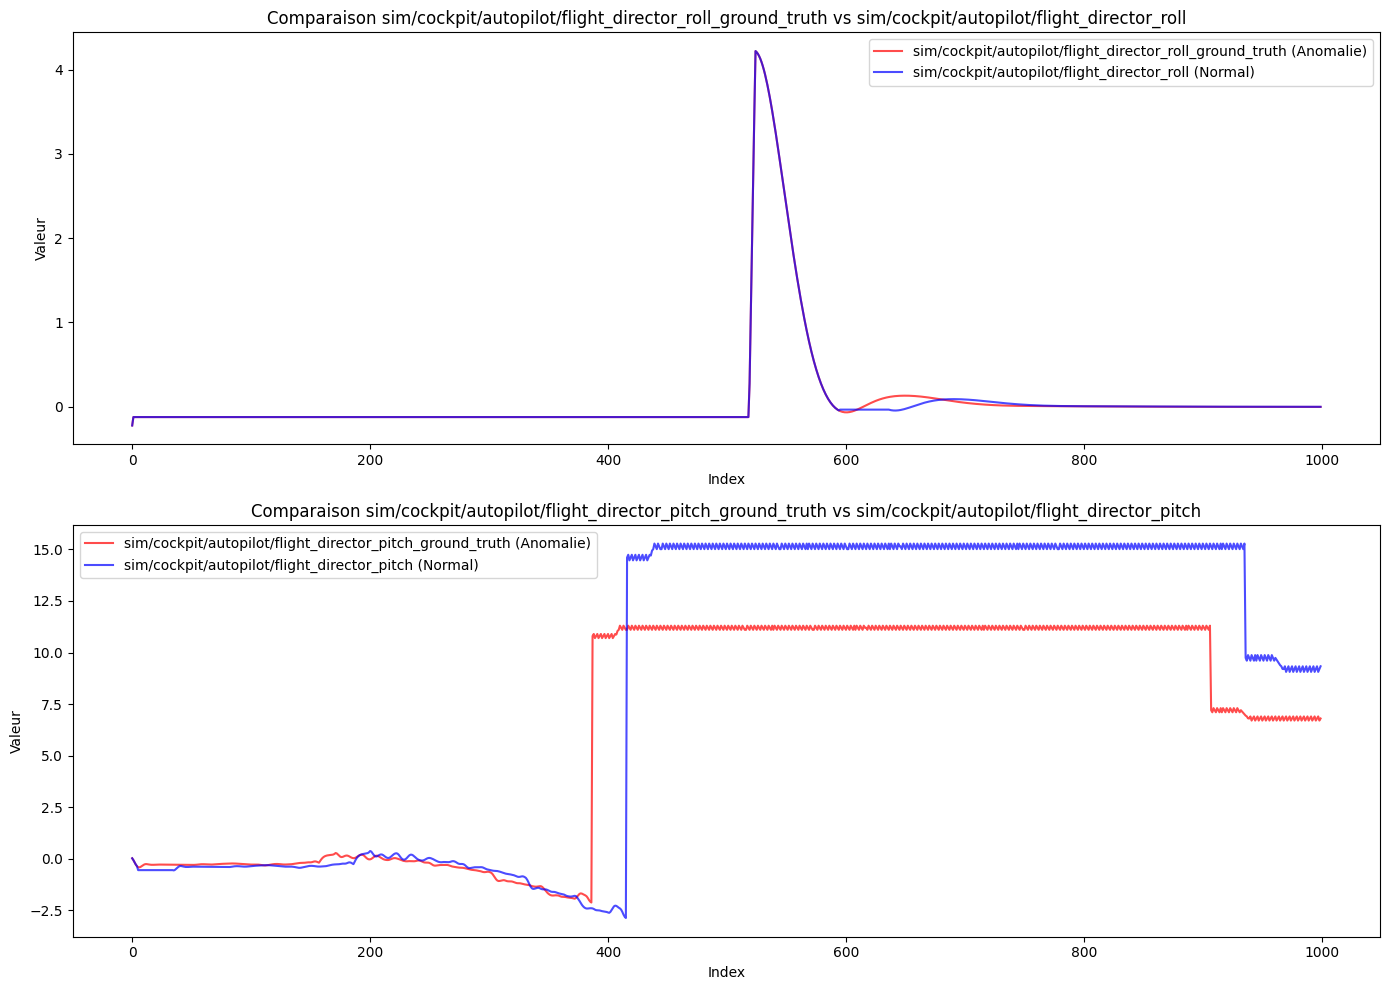

In [11]:
from sklearn.metrics import mean_squared_error

def afficher_comparaison_mse_anomalies_et_normaux(anomalie_param1, anomalie_param2, normal_param1, normal_param2, anormal_data):
    # Extraire les colonnes des données anormales et normales
    anormal_1 = anormal_data[anomalie_param1]
    anormal_2 = anormal_data[anomalie_param2]
    normal_1 = anormal_data[normal_param1]
    normal_2 = anormal_data[normal_param2]
    
    
    # Calcul de la MSE entre les paramètres anormaux et normaux 
    mse_1 = mean_squared_error(anormal_1, normal_1)  
    mse_2 = mean_squared_error(anormal_2, normal_2)  
    
    # Affichage des MSE
    print(f"MSE pour {anomalie_param1} vs {normal_param1}: {mse_1:.4f}")
    print(f"MSE pour {anomalie_param2} vs {normal_param2}: {mse_2:.4f}")
    
    # Affichage des courbes
    plt.figure(figsize=(14, 10))
    
    # Comparaison des paramètres anormaux vs normaux
    plt.subplot(2, 1, 1)
    plt.plot(anormal_1[:1000], label=f'{anomalie_param1} (Anomalie)', color='red', alpha=0.7)
    plt.plot(normal_1[:1000], label=f'{normal_param1} (Normal)', color='blue', alpha=0.7)
    plt.title(f"Comparaison {anomalie_param1} vs {normal_param1}")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    
    plt.subplot(2, 1, 2)
    plt.plot(anormal_2[:1000], label=f'{anomalie_param2} (Anomalie)', color='red', alpha=0.7)
    plt.plot(normal_2[:1000], label=f'{normal_param2} (Normal)', color='blue', alpha=0.7)
    plt.title(f"Comparaison {anomalie_param2} vs {normal_param2}")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    
    # Affichage global
    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction
afficher_comparaison_mse_anomalies_et_normaux(
    'sim/cockpit/autopilot/flight_director_roll_ground_truth', 
    'sim/cockpit/autopilot/flight_director_pitch_ground_truth',
    'sim/cockpit/autopilot/flight_director_roll',
    'sim/cockpit/autopilot/flight_director_pitch',
    anomaly_data_frames[0]
)

In [12]:
# Colonnes à supprimer
columns_to_drop = [
    'sim/cockpit/autopilot/flight_director_roll_ground_truth',
    'sim/cockpit/autopilot/flight_director_pitch_ground_truth'
]

# Suppression des colonnes des DataFrames dans anomaly_data_frames
for i in range(len(anomaly_data_frames)):
    anomaly_data_frames[i] = anomaly_data_frames[i].drop(columns=columns_to_drop, errors='ignore')


In [13]:
print("Tailles des DataFrames dans anomaly_data_frames après l'ajustement:")
anormal_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anormal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans anomaly_data_frames après l'ajustement:
Taille (3581, 135): 36 simulations


### Division des données

In [14]:
# Diviser les données normales en ensemble d'entraînement (80%) et ensemble de test (20%)
train_normal, test_normal = train_test_split(normal_data_frames, test_size=0.2, random_state=42)

# Les données anormales seront utilisées comme ensemble de test
test_anomaly = anomaly_data_frames

print(f"Nombre de simulations pour l'entraînement (normal): {len(train_normal)}")
print(f"Nombre de simulations pour le test (normal): {len(test_normal)}")
print(f"Nombre de simulations pour le test (anormal): {len(test_anomaly)}")

Nombre de simulations pour l'entraînement (normal): 759
Nombre de simulations pour le test (normal): 190
Nombre de simulations pour le test (anormal): 36


### Préparation des données

In [15]:
# Fonction pour normaliser et convertir les DataFrames en tableau numpy
def prepare_data(dataframes):
    """
    Prépare les données pour le modèle LSTM:
    - Convertit les DataFrames en tableaux numpy.
    - Normalise les valeurs avec StandardScaler.

    Paramètres:
    - dataframes (list): Liste de DataFrames.

    Retourne:
    - numpy.array: Données normalisées sous forme de tableau numpy.
    """
    scaler = StandardScaler()
    # Convertir les DataFrames en tableau numpy et normaliser
    data_array = [df.values for df in dataframes]
    data_array = np.array([scaler.fit_transform(simulation) for simulation in data_array])
    return np.array(data_array)

# Normalisation et conversion des données
train_normal_data = prepare_data(train_normal)
test_normal_data = prepare_data(test_normal)
test_anomaly_data = prepare_data(test_anomaly)

print(f"Taille des données d'entraînement: {train_normal_data.shape}")
print(f"Taille des données de test (normal): {test_normal_data.shape}")
print(f"Taille des données de test (anormal): {test_anomaly_data.shape}")

Taille des données d'entraînement: (759, 3581, 135)
Taille des données de test (normal): (190, 3581, 135)
Taille des données de test (anormal): (36, 3581, 135)


### Construction du modèle LSTM Autoencoder

In [17]:
# Définir les paramètres des données
timesteps = 3581  # Nombre de pas temporels
features = 135    # Nombre de caractéristiques

inputs = tf.keras.layers.Input(shape=(timesteps, features))

# LSTM Layers
encoded = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)(inputs)
encoded = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)(encoded)

# Bottleneck
bottleneck = tf.keras.layers.Dense(32, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.RepeatVector(3581)(bottleneck)
decoded = tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)(decoded)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(135))(decoded)

In [18]:
# Compile the model
autoencoder = tf.keras.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

In [23]:
# Entraîner le modèle
with tf.device('/GPU:0'):
    history = autoencoder.fit(
        train_normal_data, train_normal_data,
        epochs=5,
        batch_size=16,
        validation_data=(test_normal_data, test_normal_data),
        shuffle=True
    )

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

### Détection des anomalies

In [ ]:
# Prédire les données de test
test_normal_pred = autoencoder.predict(test_normal_data)
test_anomaly_pred = autoencoder.predict(test_anomaly_data)

# Calculer l'erreur de reconstruction (MSE - Mean Squared Error)
normal_reconstruction_error = np.mean(np.square(test_normal_data - test_normal_pred), axis=(1, 2))
anomaly_reconstruction_error = np.mean(np.square(test_anomaly_data - test_anomaly_pred), axis=(1, 2))

# Définir le seuil basé sur les données normales (95e percentile)
threshold = np.percentile(normal_reconstruction_error, 95)
print(f"Seuil pour détecter les anomalies: {threshold}")

# Identifier les anomalies
test_normal_anomalies = normal_reconstruction_error > threshold
test_anomaly_anomalies = anomaly_reconstruction_error > threshold

# Afficher les résultats
print(f"Nombre d'anomalies détectées dans le test normal: {np.sum(test_normal_anomalies)} / {len(test_normal_anomalies)}")
print(f"Nombre d'anomalies détectées dans le test anormal: {np.sum(test_anomaly_anomalies)} / {len(test_anomaly_anomalies)}")

### Visualisation des résultats

In [ ]:
# Visualiser la distribution des erreurs de reconstruction
plt.figure(figsize=(10, 6))
plt.hist(normal_reconstruction_error, bins=50, alpha=0.6, label='Données normales')
plt.hist(anomaly_reconstruction_error, bins=50, alpha=0.6, label='Données anormales')
plt.axvline(threshold, color='red', linestyle='--', label='Seuil')
plt.title('Distribution des erreurs de reconstruction')
plt.xlabel('Erreur de reconstruction')
plt.ylabel('Fréquence')
plt.legend()
plt.show()